# Thesis Dataset Preparation & Cleaning

## Importing Necessary Libraries

In [1]:
import os
import random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

## Loading the Dataset's Kaggle Path

In [2]:
# Download latest version
path = kagglehub.dataset_download("wasifmahmood01/custom-waste-classification-dataset")

print("Path to Dataset Files:", path)

100%|██████████| 5.39G/5.39G [00:48<00:00, 120MB/s]

Extracting files...


Path to Dataset Files: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1


In [3]:
for root, dirs, files in os.walk(path):
    print(root)
    # Just show first few files in each directory
    for f in files[:5]:
        print("   ", f)
    print("------")

/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train/metal waste
    metal waste (1301).jpg
    metal waste (2151).jpg
    metal waste (1215).jpg
    metal waste (1910).jpg
    metal waste (1459).jpg
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train/paper waste
    paper waste (394).jpg
    paper waste (1934).jpg
    paper waste (1689).jpg
    paper waste (1582).jpg
    paper waste (1478).jpg
------
/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train/automobile wastes
    automobile waste (1243).jpg

## Data Exploration & Preparation

In [4]:
# Update to your actual dataset path
data_dir = Path(path) / "wastes"
print("Using Data Directory:", data_dir)

Using Data Directory: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes


In [5]:
train_dir = data_dir / "train"
test_dir = data_dir / "test"

               Class  Image_Count
7        paper waste         1370
8      plastic waste         1315
0            E-waste         1248
5        metal waste         1231
3        glass waste         1022
6      organic waste          889
1  automobile wastes          871
2      battery waste          848
4        light bulbs          420


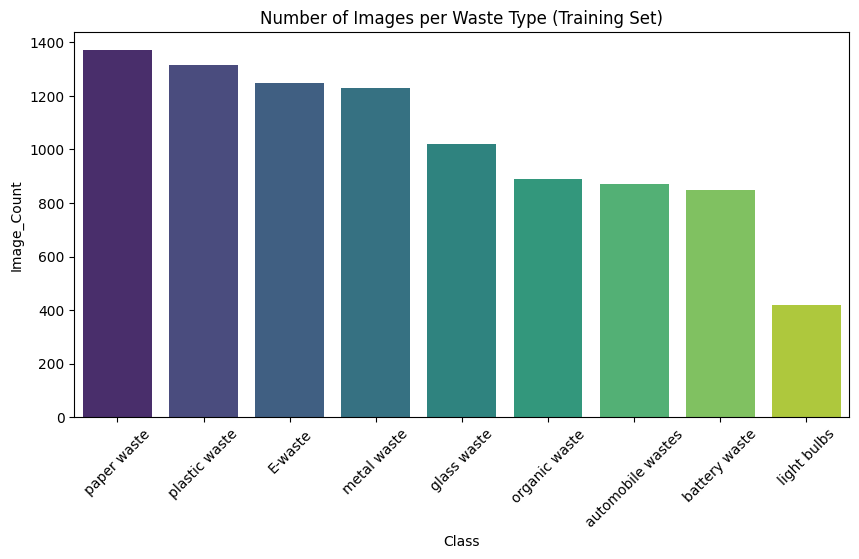

In [6]:
# Count the number of images in each class (from train directory)
classes = sorted(os.listdir(train_dir))
counts = {cls: len(os.listdir(train_dir / cls)) for cls in classes}

df_counts = pd.DataFrame(list(counts.items()), columns = ['Class', 'Image_Count']) \
               .sort_values(by = 'Image_Count', ascending = False)

print(df_counts)

plt.figure(figsize = (10,5))
sns.barplot(data = df_counts, x = 'Class', y = 'Image_Count', hue = 'Class', palette = 'viridis', legend = False)
plt.title("Number of Images per Waste Type (Training Set)")
plt.xticks(rotation = 45)
plt.show()

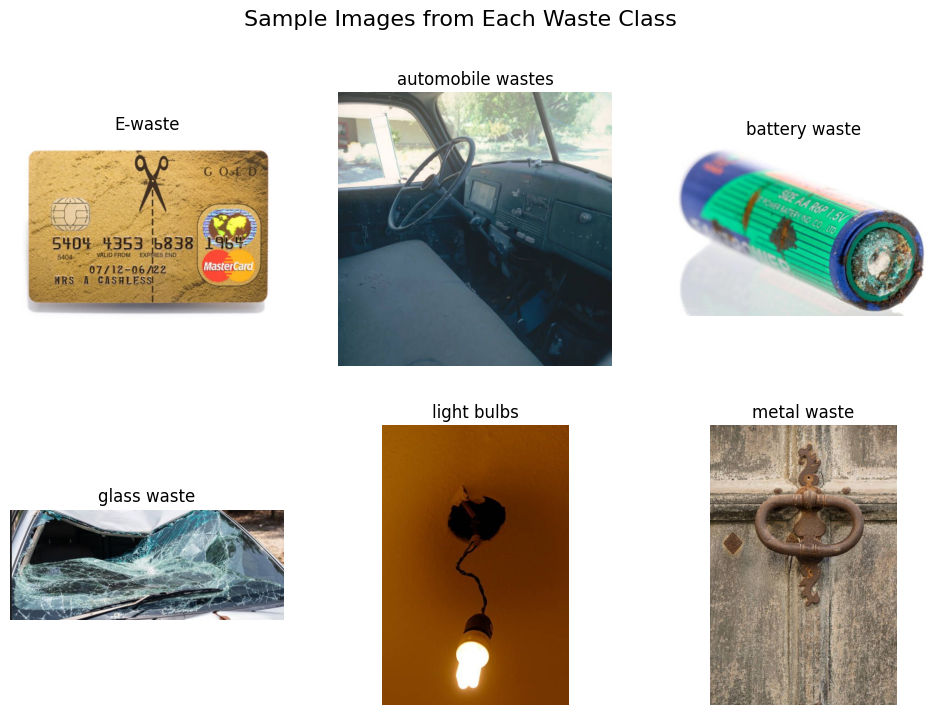

In [7]:
# Preview sample images from each waste class
fig, axes = plt.subplots(2, 3, figsize = (12,8))

for ax, cls in zip(axes.flatten(), classes):
    img_path = train_dir / cls / random.choice(os.listdir(train_dir / cls))
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

plt.suptitle("Sample Images from Each Waste Class", fontsize=16)
plt.show()

In [8]:
# Are there any corrupted images? (scanning the training set)
corrupted = []

for cls in classes:
    folder = train_dir / cls
    for file in os.listdir(folder):
        path_img = folder / file
        try:
            img = Image.open(path_img)
            img.verify()
        except:
            corrupted.append(str(path_img))

print(f"{len(corrupted)} corrupted images found.")
if corrupted:
    print("Example:", corrupted[:3])

0 corrupted images found.


Scanning plastic waste: 100%|██████████| 1315/1315 [00:00<00:00, 7742.92it/s]


             Width       Height
count  9214.000000  9214.000000
mean    949.699045   800.735620
std    1145.343332  1017.750853
min      52.000000    40.000000
25%     408.000000   324.000000
50%     586.000000   408.000000
75%     622.000000   612.000000
max    6898.000000  7262.000000


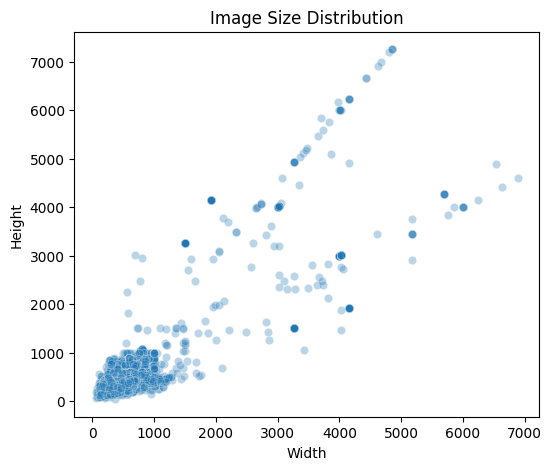

In [9]:
dims = []

for cls in classes:
    folder = train_dir / cls
    for file in tqdm(os.listdir(folder), desc = f"Scanning {cls}"):
        path_img = folder / file
        try:
            with Image.open(path_img) as img:
                dims.append(img.size)
        except:
            pass  # catch corrupted images

df_dims = pd.DataFrame(dims, columns = ['Width', 'Height'])
print(df_dims.describe())

plt.figure(figsize = (6,5))
sns.scatterplot(data = df_dims, x = 'Width', y = 'Height', alpha = 0.3)
plt.title("Image Size Distribution")
plt.show()

## Adding Generators

In [10]:
img_size = (224, 224) # Will define a new image size variable equal to (300, 300) for the B3 model
batch_size = 32

# Training DataGenerator with a validation split (because we don't have a validation folder)
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2
)

# Test/Val DataGenerator (no augmentation)
val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Training generator (80% of train)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

# Validation Generator (20% of train)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    shuffle = False
)

# Testing Generator (An independent folder)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False
)

print("Class Indices:", train_generator.class_indices)

Found 7374 images belonging to 9 classes.
Found 1840 images belonging to 9 classes.
Found 2308 images belonging to 9 classes.
Class Indices: {'E-waste': 0, 'automobile wastes': 1, 'battery waste': 2, 'glass waste': 3, 'light bulbs': 4, 'metal waste': 5, 'organic waste': 6, 'paper waste': 7, 'plastic waste': 8}


In [11]:
# Compute class weights to handle class imbalance
y_classes = train_generator.classes

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(y_classes),
    y = y_classes
)

class_weights = dict(enumerate(class_weights))

print("\nClass Weights:")
print(class_weights)


Class Weights:
{0: np.float64(0.8201534868201534), 1: np.float64(1.1755141080822573), 2: np.float64(1.2066764850270004), 3: np.float64(1.0016299918500406), 4: np.float64(2.4384920634920637), 5: np.float64(0.8318104906937395), 6: np.float64(1.150749063670412), 7: np.float64(0.7475669099756691), 8: np.float64(0.7788339670468948)}


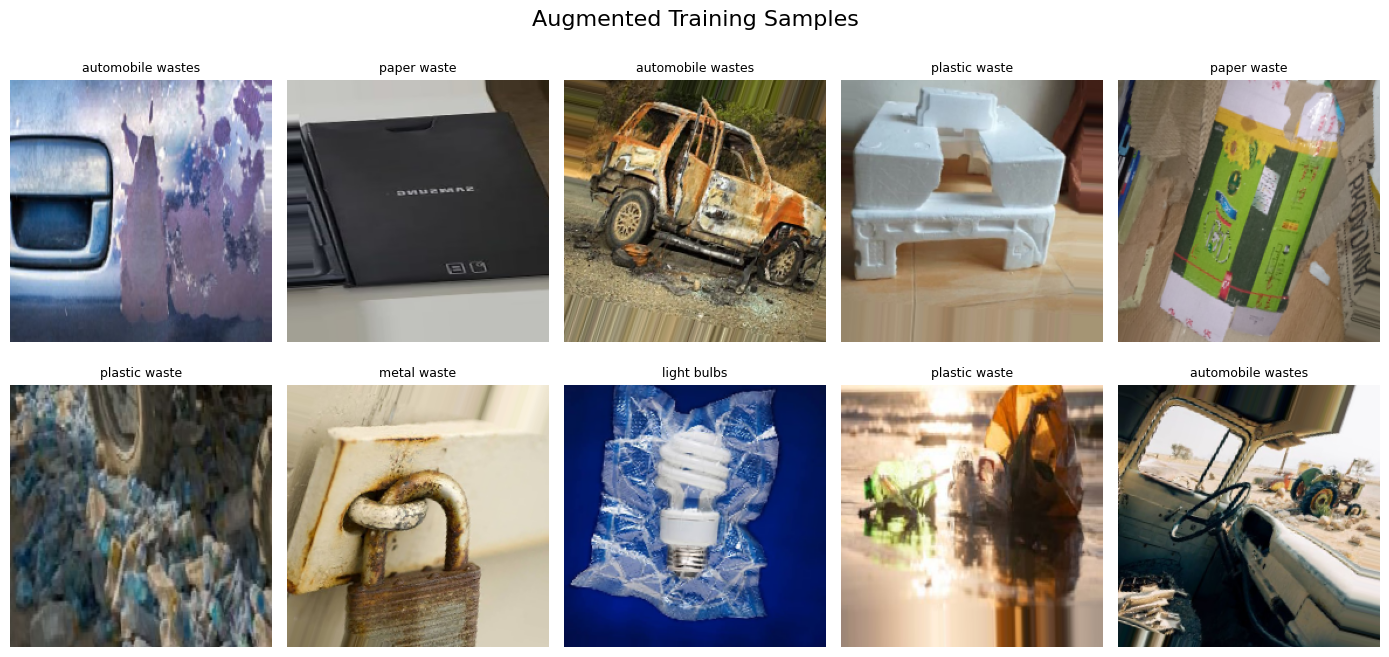

In [12]:
# Visualize Augmented Samples
x_batch, y_batch = next(train_generator)
labels_map = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(14, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_batch[i])
    cls_idx = np.argmax(y_batch[i])
    plt.title(labels_map[cls_idx], fontsize=9)
    plt.axis("off")

plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()